In [10]:
from gridenv import GridWorld, GridWorldRand
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import MathematicalProgram, IrisOptions, Hyperellipsoid, Solve, Iris
from ellipse_utils import plot_ellipse, get_seed_ellipse

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
from seeding_utils import point_near_regions, point_in_regions, vis_reg, sorted_vertices
from scipy.sparse import lil_matrix
from region_generation import generate_regions_multi_threading_regobs
from tqdm import tqdm
from pydrake.all import HPolyhedron, VPolytope
import shapely
from shapely.ops import cascaded_union 
from functools import partial  

In [22]:
from doublegreedyhiddenset import HiddensetDoubleGreedy
from utils import generate_random_colors


boxes = 4
size  = 10
N = 10000
use_region_visibility_obstacles = False
use_region_obstacles_iris = True
eps_sample = 0.1

seed = 10 #np.random.randint(0,120)
world = GridWorldRand(boxes,
		       		  rand=1.0, 
					  side_len=size, 
					  seed = seed, 
					  eps_offset=eps_sample)




def sample_cfree_handle(n, m, regions=None):
	points = np.zeros((n,2))
	if regions is None: regions = []		
	for i in range(n):
		bt_tries = 0
		while bt_tries<m:
			point = world.sample_cfree_offset(1)[0]
			#point = world.sample_cfree(1)[0]
			if point_near_regions(point, regions, tries = 100, eps = 0.1):
				bt_tries+=1
			else:
				break
		if bt_tries == m:
			return points, True
		
		points[i] = point
	return points, False

def vgraph_builder(points, regions, region_vis_obstacles=use_region_visibility_obstacles):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			if region_vis_obstacles:
				if vis_reg(point, other, world, regions):
					adj_mat[i,j] = adj_mat[j,i] = 1
			else:
				if vis_reg(point, other, world, []):
					adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()



def compute_coverage(regions):
	shapely_regions = []
	for r in regions:
		verts = sorted_vertices(VPolytope(r))
		shapely_regions.append(shapely.Polygon(verts.T))
	union_of_Polyhedra = cascaded_union(shapely_regions)
	return union_of_Polyhedra.area/world.cfree_polygon.area

def compute_coverage_cfree_tot(regions):
	shapely_regions = []
	for r in regions:
		verts = sorted_vertices(VPolytope(r))
		shapely_regions.append(shapely.Polygon(verts.T))
	union_of_Polyhedra = cascaded_union(shapely_regions)
	return union_of_Polyhedra.area/world.cfree_polygon.area

# def iris_w_obstacles(points, region_obstacles, old_regions = None, use_region_obstacles = use_region_obstacles_iris):
# 	if N>1:
# 		#+ region_obstacles
# 		obstacles = [r for r in world.obstacle_triangles]
# 		if use_region_obstacles:
# 			obstacles += region_obstacles
# 		regions, _, is_full = generate_regions_multi_threading(points, obstacles, world.iris_domain, compute_coverage, coverage_threshold=1-eps, old_regs = old_regions)
# 	else:
# 		#if N=1 coverage estimate happens at every step
# 		obstacles = [r for r in world.obstacle_triangles]
# 		if use_region_obstacles:
# 			obstacles += region_obstacles
# 		regions, _, _ = generate_regions_multi_threading(points, obstacles, world.iris_domain)
# 		is_full = 1-eps <= compute_coverage(old_regions+regions)
# 	return regions, is_full

def iris_w_obstacles(points, region_obstacles, old_regions = None, use_region_obstacles = use_region_obstacles_iris):
	if N>1:
		#+ region_obstacles
		#obstacles = [r for r in world.obstacle_triangles]
		# if use_region_obstacles:
		# 	obstacles += region_obstacles
		regions, _, is_full = generate_regions_multi_threading_regobs(points, [r for r in world.obstacle_triangles], region_obstacles, world.iris_domain, compute_coverage, coverage_threshold=1-eps, old_regs = old_regions, noregits = 3)
	else:
		#if N=1 coverage estimate happens at every step
		obstacles = [o for o in world.obstacle_triangles]
		if use_region_obstacles:
			obstacles += region_obstacles
		regions, _, _ = generate_regions_multi_threading_regobs(points, [r for r in world.obstacle_triangles], region_obstacles, world.iris_domain, noregits = 3)
		is_full = 1-eps <= compute_coverage(old_regions+regions)
	return regions, is_full

alpha = 0.05
eps = 0.1

def mut_visreg(point, other, regions, world):
	return vis_reg(point.squeeze(), other.squeeze(), world, regions, n_checks=100)

# los_handle = partial(mut_visreg, world = world)


# dg = HiddensetDoubleGreedy(
# 		alpha=alpha,
# 		eps = 0.0001,
# 		max_samples = N,
# 		sample_node_handle=sample_cfree_handle,
# 		los_handle=los_handle,
# 		verbose=True
# 		) 

# #samples = world.sample_cfree(4)

# points1 = np.array([[-2.5, 6],[-2.5, -2],])
# points2 = np.array([[-4.5, 2],[-0.5, 2],])
# seed = points1.mean(axis =0)
# E, AE, _ = get_seed_ellipse(points1[0, :].reshape(2,1), points1[1, :].reshape(2,1), eps = 0.5)
# E2, AE, _ = get_seed_ellipse(points2[0, :].reshape(2,1), points2[1, :].reshape(2,1), eps = 0.5)

done


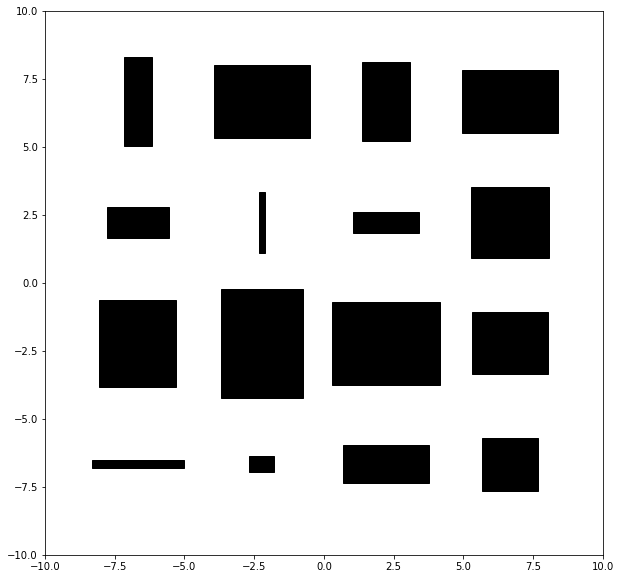

In [23]:
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
#world.plot_cfree_offset(ax)
world.plot_cfree(ax)

[16:10:29] [DoubleGreedy] New hidden point placed N =  0 it =  0
[16:10:29] [DoubleGreedy] New hidden point placed N =  1 it =  2
[16:10:29] [DoubleGreedy] New hidden point placed N =  2 it =  1
[16:10:29] [DoubleGreedy] New hidden point placed N =  3 it =  1
[16:10:30] [DoubleGreedy] New hidden point placed N =  4 it =  22
[16:10:54] [DoubleGreedy] Point budget exceeded 10000
[16:10:54] [DoubleGreedy] Computing Kernel
[16:10:54] [DoubleGreedy] Kernel of size 585 found


100%|██████████| 586/586 [02:26<00:00,  4.00it/s]


[16:13:25] [DoubleGreedy] Computing Kernel
[16:13:25] [DoubleGreedy] Kernel of size 910 found


100%|██████████| 911/911 [05:33<00:00,  2.73it/s]


[16:19:09] [DoubleGreedy] Computing Kernel
[16:19:09] [DoubleGreedy] Kernel of size 734 found


100%|██████████| 735/735 [03:48<00:00,  3.21it/s]


[16:23:03] [DoubleGreedy] Computing Kernel
[16:23:03] [DoubleGreedy] Kernel of size 383 found


100%|██████████| 384/384 [01:06<00:00,  5.75it/s]


[16:24:11] [DoubleGreedy] Computing Kernel
[16:24:11] [DoubleGreedy] Kernel of size 434 found


100%|██████████| 435/435 [01:23<00:00,  5.18it/s]


[16:25:37] [DoubleGreedy] Hidden point found to split into 2
[16:25:44] [DoubleGreedy] Computing Kernel
[16:25:44] [DoubleGreedy] Kernel of size 505 found


100%|██████████| 506/506 [01:49<00:00,  4.62it/s]


[16:27:36] [DoubleGreedy] Computing Kernel
[16:27:36] [DoubleGreedy] Kernel of size 626 found


100%|██████████| 627/627 [02:54<00:00,  3.60it/s]


[16:30:34] [DoubleGreedy] Computing Kernel
[16:30:34] [DoubleGreedy] Kernel of size 378 found


100%|██████████| 379/379 [00:59<00:00,  6.36it/s]


[16:31:35] [DoubleGreedy] Computing Kernel
[16:31:35] [DoubleGreedy] Kernel of size 261 found


100%|██████████| 262/262 [00:28<00:00,  9.23it/s]


[16:32:04] [DoubleGreedy] Computing Kernel
[16:32:04] [DoubleGreedy] Kernel of size 154 found


100%|██████████| 155/155 [00:12<00:00, 12.10it/s]


[16:32:17] [DoubleGreedy] Computing Kernel
[16:32:17] [DoubleGreedy] Kernel of size 517 found


100%|██████████| 518/518 [02:13<00:00,  3.87it/s]


hiddenset 6


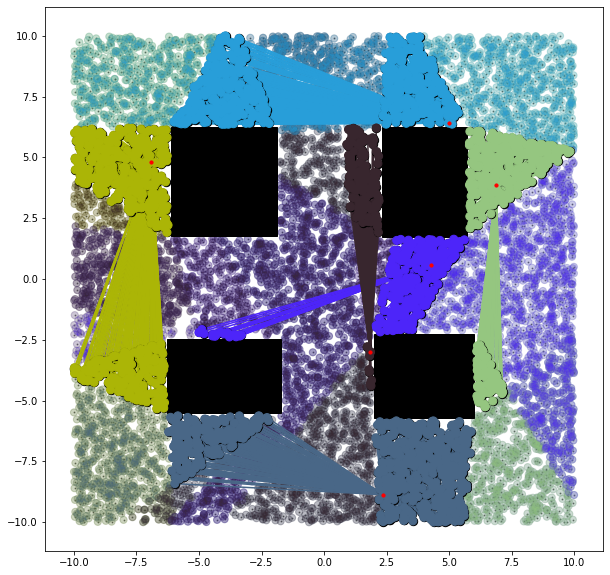

hiddenset 6


In [8]:
#dg.construct_independent_set([])

fig,ax = plt.subplots(figsize = (10,10))
# ax.set_xlim((-size, size))
# ax.set_ylim((-size, size))
#world.plot_cfree_offset(ax)
world.plot_cfree(ax)
pts = np.array(dg.points).squeeze()

ax.scatter(pts[:,0], pts[:,1], s=1, c ='k', alpha = 0.5)
# ax.scatter(pts[dg.hidden_set,0], pts[dg.hidden_set,1], s=125, c ='b', zorder = 10)

# dg.refine_independent_set_greedy([], ax)
#dg.refine_independent_set_greedy([])

print("hiddenset", len(dg.hidden_set))
colors = generate_random_colors(len(dg.hidden_set))

s_shadow =70
s_color = 65
s_sample_set = 50
# ax.scatter(pts[dg.hidden_set,0], pts[dg.hidden_set,1], s=45, c ='r', zorder = 10)

kernels = [np.array(dg.compute_kernel_of_hidden_point(p) + [dg.points[p]]).reshape(-1,2) for p in dg.hidden_set]
for c, k in zip(colors, kernels):
	ax.scatter(k[:,0], k[:,1], s = s_shadow,c = 'k', zorder = 11)
	ax.scatter(k[:,0], k[:,1], s = s_color, c = [c]*len(k), zorder = 12)
	for p in k[:-1,:]:
		ax.plot([p[0], k[-1,0]], [p[1], k[-1,1]], c =c)

for hpt_idx in dg.hidden_set:
	hpt = pts[hpt_idx].reshape(1,2)
	hpt_str = str(hpt)
	vis = []
	i = 0
	ds = 5
	for key in dg.sample_set.keys():
		# if i%ds ==0:
		# 	pass
		# else:
			point = dg.sample_set[key][0]
			visible_points = dg.sample_set[key][1]
			for p in visible_points:
				if str(p)==hpt_str:
					vis.append(point)
		# i+=1
	vis_arr = np.array(vis).reshape(-1,2)
	ax.scatter(vis_arr[:,0], vis_arr[:,1], s = s_sample_set, color = [colors[dg.hidden_set.index(hpt_idx)]]*len(vis_arr), alpha = 0.2)

ax.scatter(pts[dg.hidden_set,0], pts[dg.hidden_set,1], s=10, c ='r', zorder = 15)
plt.pause(0.01)



print("hiddenset", len(dg.hidden_set))

In [8]:
pts

array([[ 1.91048849, -8.40838642],
       [-7.51700138,  7.9559074 ],
       [ 8.87870425, -1.09734205],
       ...,
       [ 4.21751528, -2.91884317],
       [ 9.79558235,  1.78206793],
       [ 1.50857035,  6.6220029 ]])

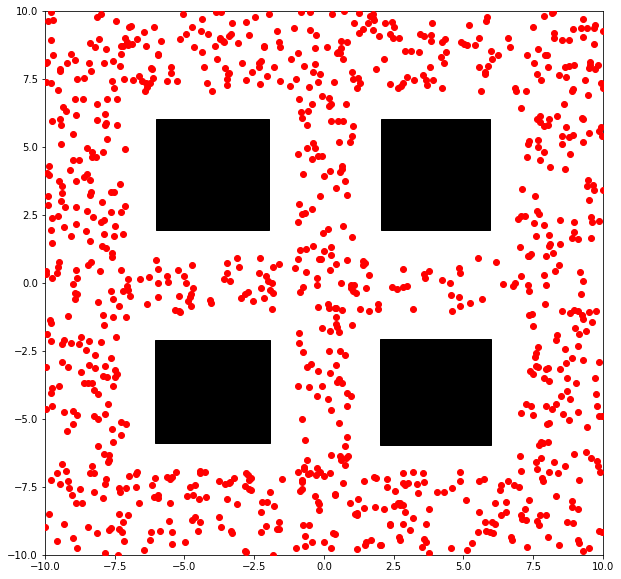

In [4]:
pts = world.sample_cfree_offset(1000)
fig,ax = plt.subplots(figsize = (10,10))
world.plot_cfree(ax)
ax.scatter(pts[:,0], pts[:,1], zorder =10, c = 'r')
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
plt.show()

In [8]:
import os
import glob
import pickle
import numpy as np

def parse_logfile(filename):
    logfile = open(filename, 'r')
    lines = logfile.readlines()
    logfile.close()

    iteration_data = []
    current_iteration = {}

    for line in lines:
        if line.startswith('ITERATION:'):
            if current_iteration:
                iteration_data.append(current_iteration)
                current_iteration = {}
        elif line.startswith('summary'):
            current_iteration['summary'] = line.strip()
        elif line.startswith('number of regions step'):
            current_iteration['number_of_regions_step'] = int(line.split()[-1])
        elif line.startswith('number of regions total'):
            current_iteration['number_of_regions_total'] = int(line.split()[-1])
        elif line.startswith('tstep'):
            a = line.replace(',', '')
            current_iteration['tstep'] = float(a.split()[1])
            current_iteration['t_total'] = float(a.split()[3])
        elif line.startswith('tsample'):
            a = line.replace(',', '')
            current_iteration['tsample'] = float(a.split()[1])
            current_iteration['t_visgraph'] = float(a.split()[3])
        elif line.startswith('t_mhs'):
            current_iteration['t_mhs'] = float(line.split()[1])
        elif line.startswith('t_regions'):
            current_iteration['t_regions'] = float(line.split()[1])
        elif line.startswith('coverage'):
            current_iteration['coverage'] = float(line.split()[1])
        elif '[VisSeeder] Coverage met, terminated' in line:
            current_iteration['termination'] = line.strip()

    if current_iteration:
        iteration_data.append(current_iteration)
    return iteration_data


logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    b = int(name_parts[2])
    N = int(name_parts[-4])
    r = float(name_parts[-1])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    pkl_files = os.listdir(data_directory)
    pkl_idx = np.argsort([int(s.replace('it_', '').replace('.pkl', '')) for s in pkl_files])
    
    #pickle_files.sort()
    
    last_pickle_file = data_directory+'/'+pkl_files[pkl_idx[-1]]#pickle_files[-1]#max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    

    iteration_dictionaries = parse_logfile(last_text_file)
    tsample = np.sum([i['tsample'] for i in iteration_dictionaries[1:]])
    tvis = np.sum([i['t_visgraph'] for i in iteration_dictionaries[1:]])
    tmhs = np.sum([0 for i in iteration_dictionaries[1:]])
    tregions = np.sum([i['t_total'] -i['t_visgraph']-i['tsample']  for i in iteration_dictionaries[1:]])
    coverage = iteration_dictionaries[-1]['coverage']
    # # Read the last line of the text file to extract coverage
    # with open(last_text_file, 'r') as file:
    #     lines = file.readlines()
    #     last_line = lines[-1].strip()
    #     coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    if r not in grouped_experiments[b]:
        grouped_experiments[b][r] = {}
        
    # Group experiments by 'N' value
    if N not in grouped_experiments[b][r]:
        grouped_experiments[b][r][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][r][N].append([
            np.sum(len(g) for g in data['rb']), coverage , data['ttotal'], tsample, tvis, tmhs, tregions])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for r, experiments_r in experiments.items():
        print(f"Experiments with r = {r}:")
        for N, experiment_data in experiments_r.items():
            print(f"  Experiments with N = {N}:")
            for dat in experiment_data:
                print(f"    Experiment data: {dat}")




Experiments with b = 3:
Experiments with r = 0.0:
  Experiments with N = 30:
    Experiment data: [12, 0.9612, 6.312995195388794, 0.275, 0.468, 0, 8.975999999999999]
    Experiment data: [10, 0.9572, 8.046150207519531, 0.321, 0.637, 0, 12.434]
    Experiment data: [9, 0.9645, 5.583374500274658, 0.327, 0.6539999999999999, 0, 8.492]
    Experiment data: [11, 0.9589, 7.552822828292847, 0.307, 0.656, 0, 11.152000000000001]
    Experiment data: [9, 0.9644, 5.728258848190308, 0.321, 0.64, 0, 8.826]
    Experiment data: [9, 0.9658, 6.5667126178741455, 0.329, 0.661, 0, 10.27]
    Experiment data: [11, 0.9764, 8.628958463668823, 0.28200000000000003, 0.603, 0, 12.452]
    Experiment data: [11, 0.9664, 5.933365106582642, 0.316, 0.507, 0, 8.407]
    Experiment data: [8, 0.9883, 4.750612497329712, 0.008, 0.17, 0, 4.573]
  Experiments with N = 300:
    Experiment data: [8, 0.9867, 23.406834840774536, 0.072, 18.72, 0, 4.615000000000001]
    Experiment data: [8, 0.9857, 22.888646125793457, 0.074, 18.3

<ipython-input-8-b13c6b8200cf>:111: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), coverage , data['ttotal'], tsample, tvis, tmhs, tregions])


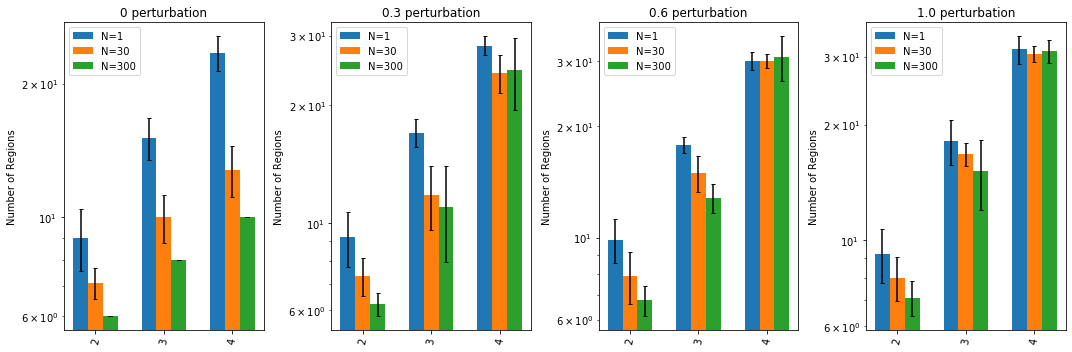

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
boxes = [2,3,4]
categories = boxes
values1 = [np.mean(grouped_experiments[b][0][1], axis =0)[0] for b in boxes]
values2 = [np.mean(grouped_experiments[b][0][30], axis =0)[0] for b in boxes]
values3 = [np.mean(grouped_experiments[b][0][300], axis =0)[0] for b in boxes]
std1 = [np.std(grouped_experiments[b][0][1], axis =0)[0] for b in boxes]
std2 = [np.std(grouped_experiments[b][0][30], axis =0)[0] for b in boxes]
std3 = [np.std(grouped_experiments[b][0][300], axis =0)[0] for b in boxes]

# Set the position of the bars on the x-axis
ind = np.arange(len(categories))*3

# Set the width of the bars
width = 0.65

# Create the figure and axes
fig, axs = plt.subplots(nrows =1, ncols = 4, figsize = (15, 5))

ax = axs[0]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='N=1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='N=30')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='N=300')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('0 perturbation')
ax.legend()

# Sample data
values1 = [np.mean(grouped_experiments[b][0.3][1], axis =0)[0] for b in boxes]
values2 = [np.mean(grouped_experiments[b][0.3][30], axis =0)[0] for b in boxes]
values3 = [np.mean(grouped_experiments[b][0.3][300], axis =0)[0] for b in boxes]
std1 = [np.std(grouped_experiments[b][0.3][1], axis =0)[0] for b in boxes]
std2 = [np.std(grouped_experiments[b][0.3][30], axis =0)[0] for b in boxes]
std3 = [np.std(grouped_experiments[b][0.3][300], axis =0)[0] for b in boxes]
ax = axs[1]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='N=1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='N=30')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='N=300')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('0.3 perturbation')
ax.legend()



values1 = [np.mean(grouped_experiments[b][0.6][1], axis =0)[0] for b in boxes]
values2 = [np.mean(grouped_experiments[b][0.6][30], axis =0)[0] for b in boxes]
values3 = [np.mean(grouped_experiments[b][0.6][300], axis =0)[0] for b in boxes]
std1 = [np.std(grouped_experiments[b][0.6][1], axis =0)[0] for b in boxes]
std2 = [np.std(grouped_experiments[b][0.6][30], axis =0)[0] for b in boxes]
std3 = [np.std(grouped_experiments[b][0.6][300], axis =0)[0] for b in boxes]

ax = axs[2]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='N=1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='N=30')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='N=300')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('0.6 perturbation')
ax.legend()


values1 = [np.mean(grouped_experiments[b][1][1], axis =0)[0] for b in boxes]
values2 = [np.mean(grouped_experiments[b][1][30], axis =0)[0] for b in boxes]
values3 = [np.mean(grouped_experiments[b][1][300], axis =0)[0] for b in boxes]
std1 = [np.std(grouped_experiments[b][1][1], axis =0)[0] for b in boxes]
std2 = [np.std(grouped_experiments[b][1][30], axis =0)[0] for b in boxes]
std3 = [np.std(grouped_experiments[b][1][300], axis =0)[0] for b in boxes]

ax = axs[3]

# Create the first set of bars
rects1 = ax.bar(ind - width, values1, width, label='N=1')
ax.errorbar(ind-width, values1, yerr=[std1, std1], fmt='none', ecolor='k', capsize=2)
# Create the second set of bars
rects2 = ax.bar(ind, values2, width, label='N=30')
ax.errorbar(ind, values2, yerr=[std2, std2], fmt='none', ecolor='k', capsize=2)

rects3 = ax.bar(ind+width, values3, width, label='N=300')
ax.errorbar(ind+width, values3, yerr=[std3, std3], fmt='none', ecolor='k', capsize=2)

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('1.0 perturbation')
ax.legend()

plt.tight_layout()
plt.savefig("cgshop_instances.pdf")

In [4]:
list( mcolors.CSS4_COLORS.keys())

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 

In [15]:
boxes = 3
size  = 10
seed = 1

world = GridWorld(boxes, side_len=size, seed = seed)

#samples = world.sample_cfree(4)

points1 = np.array([[-2.5, 6],[-2.5, -2],])
points2 = np.array([[-4.5, 2],[-0.5, 2],])
seed = points1.mean(axis =0)
E, AE, _ = get_seed_ellipse(points1[0, :].reshape(2,1), points1[1, :].reshape(2,1), eps = 0.5)
E2, AE, _ = get_seed_ellipse(points2[0, :].reshape(2,1), points2[1, :].reshape(2,1), eps = 0.5)

done


In [16]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

#iris_options.configuration_obstacles = [np.array([0])]
regions = []
succ_seed_pts = []
Es = Hyperellipsoid(E2.A(), points1[1,:].reshape(-1,1))

iris_options.initial_ellipsoid = Es
reg = Iris(world.obstacles, points1[1,:].reshape(-1,1), world.iris_domain, iris_options)

Es = Hyperellipsoid(E2.A(), seed.reshape(-1,1))
iris_options.initial_ellipsoid = Es
# iris_options.initial_ellipsoid = E2
reg2 = Iris(world.obstacles, seed.reshape(-1,1), world.iris_domain, iris_options)

In [17]:
from region_generation import generate_regions_regobs

In [18]:
seed2= 0.5*(points1[1,:].reshape(-1,1) + seed.reshape(-1,1))
Aobs = [r.A() for r in world.obstacles]
bobs = [r.b() for r in world.obstacles]
Aregobs = [r.A() for r in [reg, reg2]]
bregobs = [r.b() for r in [reg, reg2]]
Adom = world.iris_domain.A()
bdom = world.iris_domain.b()
reg3 = generate_regions_regobs([seed2], Aobs, bobs, Aregobs, bregobs, Adom, bdom, noregits=3)[0][0]

[17:48:48]  1 / 1


In [19]:
reg3

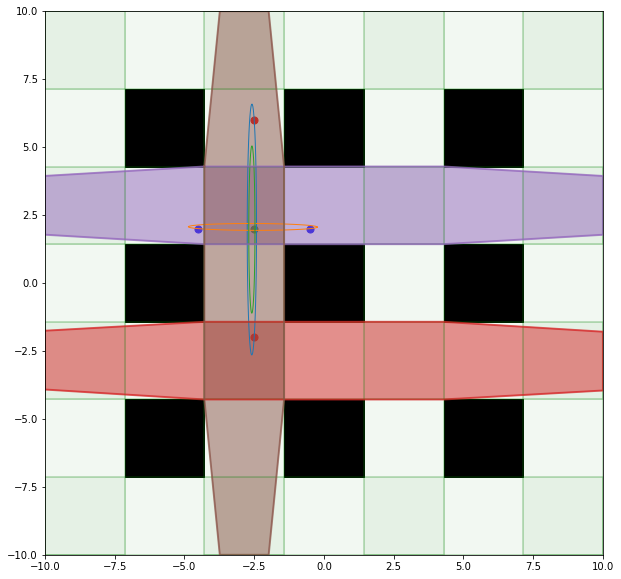

In [21]:
fig,ax = plt.subplots(figsize = (10,10))
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
ax.scatter(points1[:,0], points1[:,1], c = 'r', s = 50)
ax.scatter(points2[:,0], points2[:,1], c = 'b', s = 50)
ax.scatter(seed[0], seed[1], c = 'g', s = 50)
plot_ellipse(ax, E, 50)
plot_ellipse(ax, E2, 50)

H = Hyperellipsoid(E.A()*1.5, E.center())
plot_ellipse(ax, H, 50)

world.plot_cfree(ax)
world.plot_HPoly(ax, reg)
world.plot_HPoly(ax, reg2)
world.plot_HPoly(ax, reg3)
plt.pause(0.01)


In [4]:


# for idx, pt in enumerate(pts):
# print(time.strftime("[%H:%M:%S] ", time.gmtime()), idx+1, '/', len(pts))
# try:
#     
#     regions.append(reg)
#     succ_seed_pts.append(pt)
# except:
#     print('Iris failed at ', pt)


In [38]:
dir(iris_options)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_del_orig',
 'configuration_obstacles',
 'configuration_space_margin',
 'iteration_limit',
 'num_additional_constraint_infeasible_samples',
 'num_collision_infeasible_samples',
 'prog_with_additional_constraints',
 'random_seed',
 'relative_termination_threshold',
 'require_sample_point_is_contained',
 'termination_threshold']